<a href="https://colab.research.google.com/github/longjae/pytorch_study/blob/master/dataset_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset & Dataloader
- 데이터 샘플을 처리하는 코드는 지저분(messy)하고 유지보구사 어려울 수 있음
  - 더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적
- PyTorch는 torch.utils.data.DataLoader와 torch.utils.data.Dataset의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 함
- Dataset은 샘플과 정답(label)을 저장하고, DataLoader는 Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌈

## 데이터셋 불러오기
- TorchVision에서 Fashion-MNIST 데이터셋을 불러오는 예제
  - Zalando의 기사 이미지 데이터셋
  - 60,000개의 학습 예제와 10,000개의 테스트 예제로 구성되어 있음
  - 각 예제는 흑백(grayscale)의 28*28 이미지와 10개 분류(class) 중 하나인 정답(label)으로 구성
- 다음 매개변수들을 사용하여 Fashion-MNIST 데이터셋을 불러옴
  - root: 학습/테스트 데이터가 저장되는 경로
  - train: 학습용 또는 테스트용 데이터셋 여부를 지정
  - download = True는 root에 데이터가 없는 경우 인터넷에서 다운로드
  - transform과 target_transform은 특징(feature)과 정답(label) 변형(transform)을 지정

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16043006.20it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274167.57it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5125561.88it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13312131.31it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## 데이터셋을 순회하고 시각화하기
- Dataset에 리스트(list)처럼 직접 접근(index)할 수 있음
- training_data[index], matplotlib을 사용하여 학습 데이터의 일부를 시각화

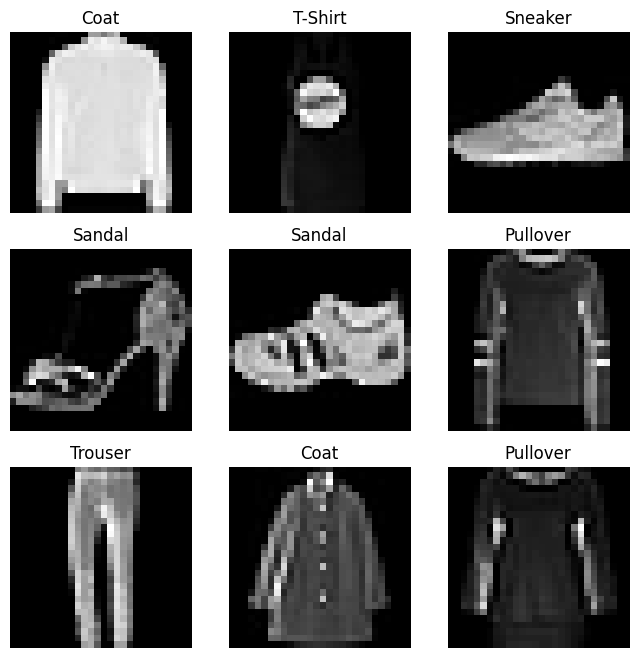

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기
- 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 함
  - \_\_init__, \_\_len__, \_\_getitem__
- FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv파일에 별도 저장됨

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

In [7]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file, names=["file_name", "label"])
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

## \_\_init__
- \_\_init__ 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행됨
- 여기 예제에서 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 두가지 변형을 초기화 함

## \_\_len__
- \_\_len__ 함수는 데이터셋의 샘플 개수를 반환

## \_\_getitem__
- \_\_getitem__ 함수는 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환함
- 인덱스를 기반으로 디스크에서 이미지의 위치를 식별하고, read_image를 사용하여 이미지를 텐서롤 반환하고, self.img_labels의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform)함수들을 호출한 뒤, 텐서 이미지와 라벨을 dict형으로 반환함

## DataLoader로 학습용 데이터 준비하기
- Dataset은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 함
- 모델을 학습할 때, 일반적으로 샘플들을 <<미니배치(minibatch)>>로 전달하고, 매 에포크(epoch)마다 데이터를 다시 섰어서 과적합(overfit)을 막고, pytho의 multiprocessing을 사용하여 데이터 검색 속도를 높이려고 함

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoader를 통해 순회하기(iterate)
- DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있음
- 예제의 각 순회(iteration)는 (각각 batch_size=64의 특징(feature)과 정답(label)을 포함하는) train_features와 train_labels의 묶음(batch)을 반환
- shuffle=True로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞임

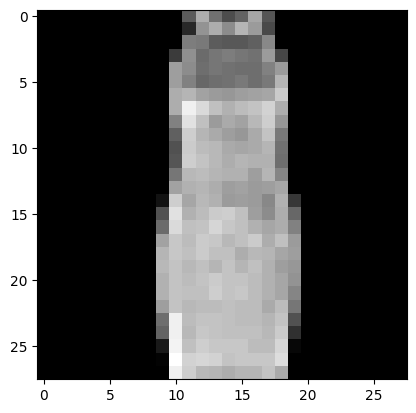

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: 3


In [11]:
# 이미지와 정답(label)을 표시함
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"Label: {label}")